In [19]:
import numpy as np

def tester(test_this, true_disp):
	# expected input shapes: (288, 384)
	old_test_this = test_this
	test_this = test_this/np.max(test_this)
	true_disp = true_disp/np.max(true_disp)
	test = (abs(test_this - true_disp) * np.max(old_test_this)).reshape(-1)
	mde = test.mean()
	testsq = ((test_this - true_disp) ** 2).reshape(-1)
	mse = testsq.mean()
	
	print("Mean disparity error:", mde, "\n", "Mean sqared error:", mse)
	stdev = np.std(test)
	
	print("Standard deviation of disparity error:", stdev)
	i=0
	
	for x in test:
		if abs(x)>=3:
			i += 1
	p = i/len(test)
	
	print("Number and fraction of large errors (error ≥ 3 pixels):", i, p)
	return [mde, mse, stdev, i, p]

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def run_stereo_matching(img1, img2, windowsize = 11, limit = 8, cv = 0):
	if cv == 1:		
		pyramid_images_img1 = gaussian_pyramid_images_cv(img1)
		pyramid_images_img2 = gaussian_pyramid_images_cv(img2)
	else:
		pyramid_images_img1 = gaussian_pyramid_images(img1)
		pyramid_images_img2 = gaussian_pyramid_images(img2)

	disparity_map = correspondence(pyramid_images_img1[3], pyramid_images_img2[3], windowsize, limit)[1]

	imgs = []
	imgs.append(disparity_map)
	
	for i in np.arange(3):
		disparity_map = cv2.pyrUp(disparity_map)
		disparity_map = np.multiply(disparity_map, 2)
		disparity_map = correspondence_upscaled(pyramid_images_img1[2-i], pyramid_images_img2[2-i], disparity_map, windowsize, limit)[1]
		imgs.append(disparity_map)
	
	return np.array(imgs)

def pextract(img, y):
	patch = np.empty_like(patch0)
	patches = np.empty_like(patches0)
	for x in range(0, ish[1]):
		a = img[y:y+windowsize,x:x+windowsize,:]
		a=((a[:,:,0]+a[:,:,1]+a[:,:,2])/3).reshape(length)
		patch = (a - np.mean(a)) / np.std(a)
		patches[x] = patch
	return patches

def pextract_lum(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        a=(a[:,:,0]*0.3+a[:,:,1]*0.6+a[:,:,2]*0.1).reshape(length)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def hpatches(img1, img2, y, mode='intensity'):
    padded1= cv2.copyMakeBorder(img1,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    padded2= cv2.copyMakeBorder(img2,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    
    if mode == 'intensity':
        patches1 = pextract(padded1, y)
        patches2 = pextract(padded2, y)
    elif mode == 'luminance':
        patches1 = pextract_lum(padded1, y)
        patches2 = pextract_lum(padded2, y)
    
    return patches1, patches2

def correspondence(img1,img2, wsize = 5, limit = 8, mode='intensity'):
	start = time.clock() 
	global windowsize
	windowsize = wsize
	global pad
	pad = (windowsize-1)//2
	global length
	length = windowsize**2
	global ish
	ish = img1.shape
	global psh
	psh = (img1.shape[0]+2*pad,img1.shape[1]+2*pad)
	global patch0
	patch0 = np.empty((windowsize,windowsize))
	global patches0
	patches0 = np.empty((psh[1]-windowsize+1, length))
	result = np.zeros((ish[0], ish[1]))
	result_nonsqrd = np.zeros((ish[0], ish[1]))
	for y in range(ish[0]):
		patches1, patches2 = hpatches(img1, img2, y, mode)
		for x in range(ish[1]):
			#normalized cross-correlation
			best = -999
			besth = -999

			r = [0, patches2.shape[0]]
			
			if x - limit > 0:
				r[0] = x - limit
			if x + limit < ish[1]:
				r[1] = x + limit
			for h in range(r[0],r[1]):
				ncc = np.correlate(patches1[x]/length, patches2[h]) 
				if ncc > best:
					best = ncc
					besth =h
			result[y,x]=(x-besth)**2
			result_nonsqrd[y,x]=abs(x-besth)
	elapsed = time.clock()
	elapsed = elapsed - start
	print ("Done. Time spent executing correspondence: ", elapsed)
	return result, result_nonsqrd


# In[109]:


def correspondence_upscaled(image1, image2, disparity, wsize, limit = 8, mode='intensity'):
	global windowsize
	windowsize = wsize
	global pad
	pad = (windowsize-1)//2
	global length
	length = windowsize**2
	global ish
	ish = image1.shape
	global psh
	psh = (image1.shape[0]+2*pad,image1.shape[1]+2*pad)
	global patch0
	patch0 = np.empty((windowsize,windowsize))
	global patches0
	patches0 = np.empty((psh[1]-windowsize+1, length))

	result = np.zeros((ish[0], ish[1]))
	result_nonsqrd = np.zeros((ish[0], ish[1]))

	results = []
	results_nonsqrd = []

	disp_map = disparity

		
	start = time.clock() 

	for y in range(ish[0]):
		patches1, patches2 = hpatches(image1, image2, y, mode)

		for x in range(ish[1]):
			#normalized cross-correlation
			best = -999
			besth = -999

			r = [0, patches2.shape[0]]
			
			rr = int(abs(disp_map[y,x])) #limits search range
			x_new = x + rr
			
			if x_new - limit > 0:
				r[0] = x_new - limit
			if x_new + limit < ish[1]:
				r[1] = x_new + limit
				
			for h in range(r[0],r[1]):
				ncc = np.correlate(patches1[x]/length, patches2[h]) 

				if ncc > best:
					best = ncc
					besth =h

			result[y,x]=(x-besth)**2
			result_nonsqrd[y,x]=abs(x-besth)

	results.append(result)
	results_nonsqrd.append(result_nonsqrd)

	disp_map = result

	elapsed = time.clock()
	elapsed = elapsed - start
	print ("Done. Time spent executing correspondence: ", elapsed)
	return result, result_nonsqrd

# OpenCV's own implementation

def gaussian_pyramid_images_cv(img):
	p_imgs = [img]
	for i in np.arange(3):
		img = cv2.pyrDown(img)
		p_imgs.append(img)
	return p_imgs

# Selfimplemented Gaussian Pyramid function.
# Convolves with a Gaussian kernel and then removes all even rows and columns.
# Output is four images at a higher pyramid level and therefore lower resolution. 

def gaussian_pyramid_images(img):
	p_imgs = [img]

	for i in np.arange(3):
		img = cv2.GaussianBlur(img, (5,5), 2)
		img_new = []
		for i in np.arange(1,img.shape[0],2):
			img_row = []
			for j in np.arange(1,img.shape[1],2):
				img_row.append(img[i][j])
			img_new.append(img_row)
			
		img = np.array(img_new)
		p_imgs.append(img)
		
	return p_imgs


def gaussian_pyramid_images_cv_up(images):
	p_imgs = []
	for i in np.arange(images.shape[0]):
		img = images[i]
		for j in np.arange(i):
			img = cv2.pyrUp(img)
		
		print(img.shape)
		p_imgs.append(img)
	return np.array(p_imgs)


def plot_images(imgs):
	i, j = len(imgs)//2, len(imgs)//2
	fig, ax = plt.subplots(i, j, figsize=(15,15))
	ii, jj = np.meshgrid(np.arange(i), np.arange(j), indexing='ij')
	axes = [axis for axis in zip(ii.ravel(), jj.ravel())]
	for idx, axis in enumerate(axes):
		ax[axis].imshow(imgs[idx], "gray")
	plt.show()

print('Loading packages')
import cv2
import matplotlib.pyplot as plt
#import xlwt

print('Loading self-written functions')
#from correspondence import *
#from statistics import *

print('Loading images')
img_01 = cv2.imread('images/scene1.row3.col1.ppm')
img_01_tsu = cv2.cvtColor(img_01,cv2.COLOR_BGR2RGB)
img_02 = cv2.imread('images/scene1.row3.col2.ppm')
img_02_tsu = cv2.cvtColor(img_02,cv2.COLOR_BGR2RGB)
truedisp_tsu = cv2.imread('images/truedisp.row3.col3.pgm', 0)

img_01_venus = cv2.imread('images/im0_venus.ppm')
img_01_venus = cv2.cvtColor(img_01_venus,cv2.COLOR_BGR2RGB)
img_02_venus = cv2.imread('images/im1_venus.ppm')
img_02_venus = cv2.cvtColor(img_02_venus,cv2.COLOR_BGR2RGB)

img_01_map = cv2.imread('images/im0_map.pgm')
img_01_map = cv2.cvtColor(img_01_map,cv2.COLOR_BGR2RGB)
img_02_map = cv2.imread('images/im1_map.pgm')
img_02_map = cv2.cvtColor(img_02_map,cv2.COLOR_BGR2RGB)

ground_venus = cv2.imread('venus/disp2.pgm', 0)

print('What image do you want to use? ')
img_title = input("-->")

#book = xlwt.Workbook()

window_sizes = [7,9,11,13,15]
outcome = ["Mean disparity error", "Mean squared error", "Standard deviation of disparity error", "Nr of large errors", "Fraction of large errors"]
margins = [1,3,5]



# print('What window size do you want to use? ')
# window_size = input("-->")
# window_size = int(window_size)

if img_title == "Tsukuba":
    print(' ')
    
    for indexing, margin in enumerate(margins[0:1]):
#         sh = book.add_sheet("Tsukuba_%s" %margin)

#         for index, each in enumerate(window_sizes):
#             sh.write(0, index+1, each)

#         for index, every in enumerate(outcome):
#             sh.write(index+1, 0, every)
        
        for index, window_size in enumerate(window_sizes):
            
            print('Start pyramidal stereo matching - Tsukuba')
            disparity_map_tsu = run_stereo_matching(img_01_tsu, img_02_tsu, windowsize = window_size, limit=margin)
            
            print('\n -------------------------------------- \n')
            print('STATISTICS FOR WINDOW SIZE ', window_size, '=')
            vars = tester(disparity_map_tsu[3], truedisp_tsu)
            print('\n -------------------------------------- \n')

#            for ind, var in enumerate(vars):
#                sh.write(ind+1, index+1, var)
        
    print(' ')
    print('Scale and save Tsubuka image')
    scaling = np.max(disparity_map_tsu[3])
    image_tsu = np.multiply(disparity_map_tsu[3], scaling)
    cv2.imwrite('disparity_tsu_new.png',image_tsu)
    
if img_title == "Venus":
    print('Start pyramidal stereo matching - Venus')
    disparity_map_venus = run_stereo_matching(img_01_venus, img_02_venus, cv = 1)
    
    print('\n -------------------------------------- \n')
    print('STATISTICS FOR WINDOW SIZE ', window_size, '=')
    print(tester(disparity_map_venus[3], ground_venus))
    print('\n -------------------------------------- \n')

    print('Scale and save Venus image')
    scaling = np.max(disparity_map_venus[3])
    image_venus = np.multiply(disparity_map_venus[3], scaling)
    cv2.imwrite('disparity_venus.png',image_venus)
    print(' ')
if img_title == "Map":
    print(' ')
    print('Start pyramidal stereo matching - Map')
    disparity_map_map = run_stereo_matching(img_01_map, img_02_map, cv = 1)

    print('Scale and save Map image')
    scaling = np.max(disparity_map_map[3])
    image_map = np.multiply(disparity_map_map[3], scaling)
    cv2.imwrite('disparity_map.png',image_map)
print(' ')


#book.save("stats_%s.xls" %img_title)


In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def run_stereo_matching(img1, img2, windowsize = 11, limit = 8, cv = 0):
    if cv == 1:        
        pyramid_images_img1 = gaussian_pyramid_images_cv(img1)
        pyramid_images_img2 = gaussian_pyramid_images_cv(img2)
    else:
        pyramid_images_img1 = gaussian_pyramid_images(img1)
        pyramid_images_img2 = gaussian_pyramid_images(img2)

    disparity_map = correspondence(pyramid_images_img1[3], pyramid_images_img2[3], windowsize, limit)[1]

    imgs = []
    imgs.append(disparity_map)
    
    for i in np.arange(3):
        disparity_map = cv2.pyrUp(disparity_map)
        disparity_map = np.multiply(disparity_map, 2)
        disparity_map = correspondence_upscaled(pyramid_images_img1[2-i], pyramid_images_img2[2-i], disparity_map, windowsize, limit)[1]
        imgs.append(disparity_map)
    
    return np.array(imgs)

def pextract(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        a=((a[:,:,0]+a[:,:,1]+a[:,:,2])/3).reshape(length)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def pextract_lum(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        a=(a[:,:,0]*0.3+a[:,:,1]*0.6+a[:,:,2]*0.1).reshape(length)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def hpatches(img1, img2, y, mode='intensity'):
    padded1= cv2.copyMakeBorder(img1,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    padded2= cv2.copyMakeBorder(img2,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    
    if mode == 'intensity':
        patches1 = pextract(padded1, y)
        patches2 = pextract(padded2, y)
    elif mode == 'luminance':
        patches1 = pextract_lum(padded1, y)
        patches2 = pextract_lum(padded2, y)
    
    return patches1, patches2

def correspondence(img1,img2, wsize = 5, limit = 8, mode='intensity'):
    start = time.clock() 
    global windowsize
    windowsize = wsize
    global pad
    pad = (windowsize-1)//2
    global length
    length = windowsize**2
    global ish
    ish = img1.shape
    global psh
    psh = (img1.shape[0]+2*pad,img1.shape[1]+2*pad)
    global patch0
    patch0 = np.empty((windowsize,windowsize))
    global patches0
    patches0 = np.empty((psh[1]-windowsize+1, length))
    result = np.zeros((ish[0], ish[1]))
    result_nonsqrd = np.zeros((ish[0], ish[1]))
    for y in range(ish[0]):
        patches1, patches2 = hpatches(img1, img2, y, mode)
        for x in range(ish[1]):
            #normalized cross-correlation
            best = -999
            besth = -999
            ###
            r = [0, patches2.shape[0]]
            
            if x - limit > 0:
                r[0] = x - limit
            if x + limit < ish[1]:
                r[1] = x + limit
            ###    
            for h in range(r[0],r[1]):
                ncc = np.correlate(patches1[x]/length, patches2[h]) 
                if ncc > best:
                    best = ncc
                    besth =h
            result[y,x]=(x-besth)**2
            result_nonsqrd[y,x]=x-besth
    elapsed = time.clock()
    elapsed = elapsed - start
    print ("Done. Time spent executing correspondence: ", elapsed)
    return result, result_nonsqrd




def correspondence_upscaled(image1, image2, disparity, wsize, limit = 8, mode='intensity'):
    global windowsize
    windowsize = wsize
    global pad
    pad = (windowsize-1)//2
    global length
    length = windowsize**2
    global ish
    ish = image1.shape
    global psh
    psh = (image1.shape[0]+2*pad,image1.shape[1]+2*pad)
    global patch0
    patch0 = np.empty((windowsize,windowsize))
    global patches0
    patches0 = np.empty((psh[1]-windowsize+1, length))

    result = np.zeros((ish[0], ish[1]))
    result_nonsqrd = np.zeros((ish[0], ish[1]))

    results = []
    results_nonsqrd = []

    disp_map = disparity

        
    start = time.clock() 

    for y in range(ish[0]):
        patches1, patches2 = hpatches(image1, image2, y, mode)

        for x in range(ish[1]):
            #normalized cross-correlation
            best = -999
            besth = -999
            ###
            r = [0, patches2.shape[0]]
            #print(r)
            #rr = int(abs(disp_map[y,x]))+1 #limits search range
            rr = limit
            #print(rr)  ####
            z = int(x + disp_map[y,x])
            if z - rr > 0 and z + rr < ish[1]:
                r[0] = z - rr
                r[1] = z + rr
            #print(r)
            ###    
            for h in range(r[0],r[1]):
                ncc = np.correlate(patches1[x]/length, patches2[h]) 

                if ncc > best:
                    best = ncc
                    besth =h
            
            result[y,x]=(x-besth)**2
            result_nonsqrd[y,x]=x-besth
            if abs(result_nonsqrd[y,x]) > 1000:
                print(x, r, rr, result_nonsqrd[y,x])
    print(np.max(disp_map))
    results.append(result)
    results_nonsqrd.append(result_nonsqrd)

    
    print(np.max(result_nonsqrd))
    elapsed = time.clock()
    elapsed = elapsed - start
    print ("Done. Time spent executing correspondence: ", elapsed)
    return result, result_nonsqrd

# OpenCV's own implementation

def gaussian_pyramid_images_cv(img):
    p_imgs = [img]
    for i in np.arange(3):
        img = cv2.pyrDown(img)
        p_imgs.append(img)
    return p_imgs

# Selfimplemented Gaussian Pyramid function.
# Convolves with a Gaussian kernel and then removes all even rows and columns.
# Output is four images at a higher pyramid level and therefore lower resolution. 

def gaussian_pyramid_images(img):
    p_imgs = [img]

    for i in np.arange(3):
        img = cv2.GaussianBlur(img, (5,5), 2)
        img_new = []
        for i in np.arange(1,img.shape[0],2):
            img_row = []
            for j in np.arange(1,img.shape[1],2):
                img_row.append(img[i][j])
            img_new.append(img_row)
            
        img = np.array(img_new)
        p_imgs.append(img)
        
    return p_imgs


def gaussian_pyramid_images_cv_up(images):
    p_imgs = []
    for i in np.arange(images.shape[0]):
        img = images[i]
        for j in np.arange(i):
            img = cv2.pyrUp(img)
        
        print(img.shape)
        p_imgs.append(img)
    return np.array(p_imgs)


def plot_images(imgs):
    i, j = len(imgs)//2, len(imgs)//2
    fig, ax = plt.subplots(i, j, figsize=(15,15))
    ii, jj = np.meshgrid(np.arange(i), np.arange(j), indexing='ij')
    axes = [axis for axis in zip(ii.ravel(), jj.ravel())]
    for idx, axis in enumerate(axes):
        ax[axis].imshow(imgs[idx], "gray")
    plt.show()

plt.imshow(img_01)
plt.show()

Loading packages
Loading self-written functions
Loading images
What image do you want to use? 
 
Start pyramidal stereo matching - Tsukuba
Done. Time spent executing correspondence:  0.2501560000000609
8.375
88.0
Done. Time spent executing correspondence:  1.285289999999918
141.5
186.0
Done. Time spent executing correspondence:  5.378903000000037
356.0
379.0
Done. Time spent executing correspondence:  25.477100999999948

 -------------------------------------- 

STATISTICS FOR WINDOW SIZE  9 =
Mean disparity error: 151.095798714 
 Mean sqared error: 0.22791730159
Standard deviation of disparity error: 99.5405883474
Number and fraction of large errors (error ≥ 3 pixels): 103058 0.9318757233796297

 -------------------------------------- 

 
Scale and save Tsubuka image


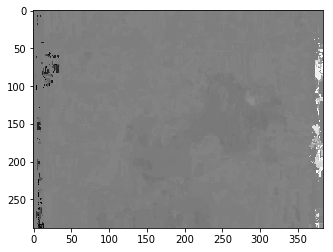

In [89]:
print('Loading packages')
import cv2
import matplotlib.pyplot as plt
#import xlwt

print('Loading self-written functions')
#from correspondence import *
#from statistics import *

print('Loading images')
img_01 = cv2.imread('images/scene1.row3.col1.ppm')
img_01_tsu = cv2.cvtColor(img_01,cv2.COLOR_BGR2RGB)
img_02 = cv2.imread('images/scene1.row3.col2.ppm')
img_02_tsu = cv2.cvtColor(img_02,cv2.COLOR_BGR2RGB)
truedisp_tsu = cv2.imread('images/truedisp.row3.col3.pgm', 0)

img_01_venus = cv2.imread('images/im0_venus.ppm')
img_01_venus = cv2.cvtColor(img_01_venus,cv2.COLOR_BGR2RGB)
img_02_venus = cv2.imread('images/im1_venus.ppm')
img_02_venus = cv2.cvtColor(img_02_venus,cv2.COLOR_BGR2RGB)

img_01_map = cv2.imread('images/im0_map.pgm')
img_01_map = cv2.cvtColor(img_01_map,cv2.COLOR_BGR2RGB)
img_02_map = cv2.imread('images/im1_map.pgm')
img_02_map = cv2.cvtColor(img_02_map,cv2.COLOR_BGR2RGB)

ground_venus = cv2.imread('venus/disp2.pgm', 0)

print('What image do you want to use? ')
img_title = "Tsukuba"#input("-->")

#book = xlwt.Workbook()

window_sizes = [9]#[7,9,11,13,15]
outcome = ["Mean disparity error", "Mean squared error", "Standard deviation of disparity error", "Nr of large errors", "Fraction of large errors"]
margins = [1,2,5]
margin = 8


# print('What window size do you want to use? ')
# window_size = input("-->")
# window_size = int(window_size)

if img_title == "Tsukuba":
    print(' ')
    
#    for indexing, margin in enumerate(margins[1:2]):
#         sh = book.add_sheet("Tsukuba_%s" %margin)

#         for index, each in enumerate(window_sizes):
#             sh.write(0, index+1, each)

#         for index, every in enumerate(outcome):
#             sh.write(index+1, 0, every)

    for index, window_size in enumerate(window_sizes):

        print('Start pyramidal stereo matching - Tsukuba')
        disparity_map_tsu = run_stereo_matching(img_02_tsu, img_01_tsu, windowsize = window_size, limit=margin)

        print('\n -------------------------------------- \n')
        print('STATISTICS FOR WINDOW SIZE ', window_size, '=')
        vars = tester(disparity_map_tsu[3], truedisp_tsu)
        print('\n -------------------------------------- \n')

#            for ind, var in enumerate(vars):
#                sh.write(ind+1, index+1, var)
        
    print(' ')
    print('Scale and save Tsubuka image')
    scaling = np.max(disparity_map_tsu[3])
    image_tsu = np.multiply(disparity_map_tsu[3], scaling)
    #cv2.imwrite('disparity_tsu_new.png',image_tsu)
    plt.imshow(image_tsu, "gray")
    plt.show()
    
if img_title == "Venus":
    print('Start pyramidal stereo matching - Venus')
    disparity_map_venus = run_stereo_matching(img_01_venus, img_02_venus, cv = 1)
    
    print('\n -------------------------------------- \n')
    print('STATISTICS FOR WINDOW SIZE ', window_size, '=')
    print(tester(disparity_map_venus[3], ground_venus))
    print('\n -------------------------------------- \n')

    print('Scale and save Venus image')
    scaling = np.max(disparity_map_venus[3])
    image_venus = np.multiply(disparity_map_venus[3], scaling)
    #cv2.imwrite('disparity_venus.png',image_venus)
    plt.imshow(image_venus)
    plt.show()
    print(' ')
if img_title == "Map":
    print(' ')
    print('Start pyramidal stereo matching - Map')
    disparity_map_map = run_stereo_matching(img_01_map, img_02_map, cv = 1)

    print('Scale and save Map image')
    scaling = np.max(disparity_map_map[3])
    image_map = np.multiply(disparity_map_map[3], scaling)
    #cv2.imwrite('disparity_map.png',image_map)
    plt.imshow(image_map)
    plt.show()
print(' ')


#book.save("stats_%s.xls" %img_title)


In [86]:
image_tsu.shape

x, r, rr, result_nonsqrd[y,x]

NameError: name 'x' is not defined

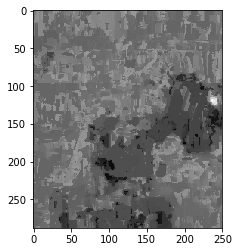

In [90]:
plt.imshow(image_tsu[:,50:300], "gray")
plt.show()

In [ ]:
np.min(image_tsu[:,:300])